In [1]:
## This code cell will not be shown in the HTML version of this notebook
#### some helpful imports ####
# import autograd functionality
import autograd.numpy as np

# import testing libraries
import sys
sys.path.append('../')
from mlrefined_libraries import time_series_lib as timelib
from mlrefined_libraries import pid_lib as pidlib

# import dataset path
datapath = '../datasets/'

# import various other libraries e.g., for plotting, deep copying
import copy
import matplotlib.pyplot as plt

# this is needed to compensate for %matplotl+ib notebook's tendancy to blow up images when plotted inline
from matplotlib import rcParams
rcParams['figure.autolayout'] = True
%matplotlib notebook

# autoreload function - so if anything behind the scenes is changeed those changes
# are reflected in the notebook without having to restart the kernel
%load_ext autoreload
%autoreload 2

In [35]:
from IPython.display import display
from IPython.display import HTML
import IPython.core.display as di # Example: di.display_html('<h3>%s:</h3>' % str, raw=True)

# This line will hide code by default when the notebook is eåxported as HTML
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

# This line will add a button to toggle visibility of code blocks, for use with the HTML export version
di.display_html('''<button onclick="jQuery('.input_area').toggle(); jQuery('.prompt').toggle();">Toggle code</button>''', raw=True)

Toggle code

# 1. Automatic control - the big picture and examples

- **over-arching goal:** control a given device / agent in order to achieve a desired outcome, automatically


- a 'device' / 'agent' can be anything, really, like
    - a machine: e.g., a car, a robotic arm, a drone
    - a 'process': e.g., a chemical mixer, temperature level in a room, customer churn
    - an 'agent': e.g., a video game AI, an 'intelligent' operator
    

- we do this by learning how to perform available *actions* that adjust a device's *state* in a desired way

#### <span style="color:#a50e3e;">Example: 1.</span>  Controlling temperature via thermostat

- your typical thermostat is a simple example of an automatic controller 


- here the
    - *device* is thermostat in a room of your home, say during the winter time
    - *state* of the room $s_t$ is its temperature at time $t$, and
    - *action* $a_t$ we can take at time $t$ is to turn on a heater and adjust the amount of *heat energy* in the room
       
    
- the setup looks like the following cartoon drawing


- note here $x_t$ denotes your *desired temperature* as set on the thermostat - this sort of *desired state* is referred to as a *set point* in the jargon of automatic control

<figure>
<p>
<img src= 'images/thermostat_system.png' width="70%" height="70%" alt=""/>
</p>
</figure>

- the 'desired states' or 'setpoints' of our agent varies throughout the day, for example
    - at night you like your room somewhat cool (you sleep better), so you set the heater on low
    - when you wake up, and until you leave for work, you like it a bit warmer, so you like the heater turned up
    - during the day (when you're not at home) you like to turn off the heat to save money
    - you like your home toasty warm when you get hone from work

- taking *actions* that adjust the *state* of the agent throughout the day to match your desired *set points* look something like the following when graphed out over a whole day

<figure>
<p>
<img src= 'images/setpoint_control_generic.png' width="70%" height="70%" alt=""/>
</p>
</figure>

 - note here:
     - that the actions taken don't force the state of the agent to perfectly allign with the desired setpoints (there is *error* between our desires and reality - what else is new?)
 
     - you could pay someone to stay at your home all day and adjust the heat level, but you want to automate this task (thats what the thermostat is for)

#### <span style="color:#a50e3e;">Example 2: </span> Single tank fill control (no drain)

<figure>
<p>
<img src= 'images/one_tank_system.png' width="40%" height="40%" alt=""/>
</p>
</figure>

- $x_t$: fill level set points

- $s_t$: actual tank level

- $a_t$: valve position (controlling much liquid enters the tank)

<IPython.core.display.Javascript object>


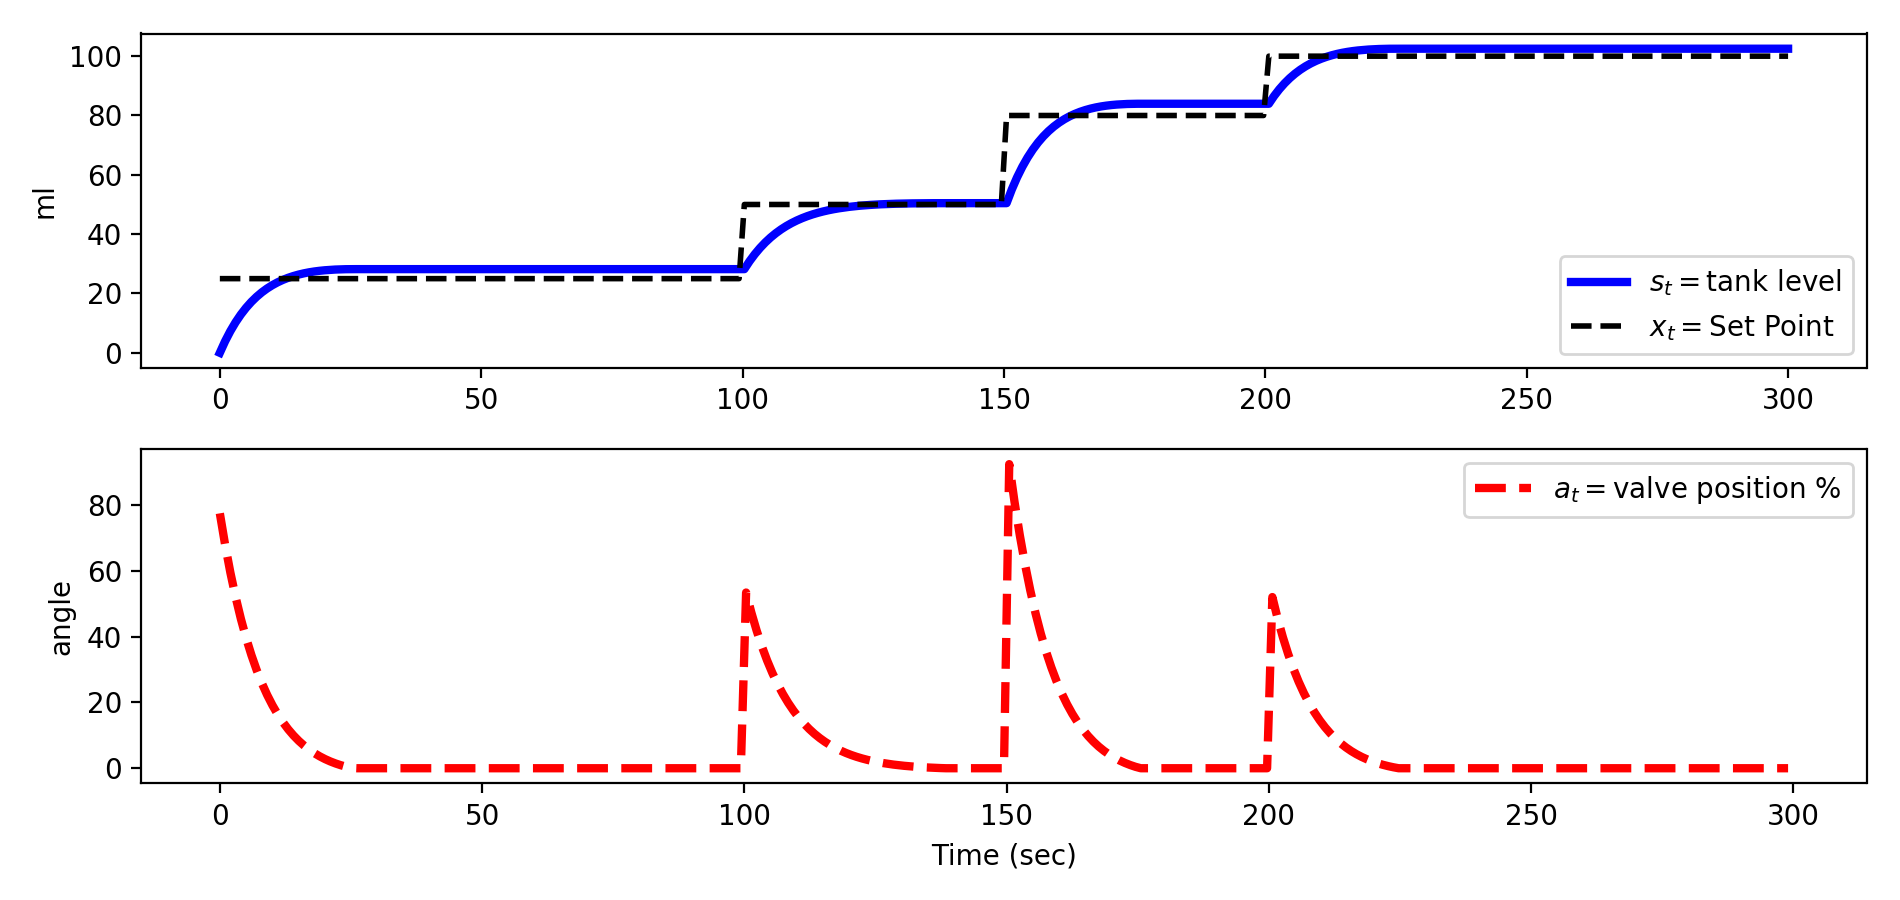

In [3]:
## This code cell will not be shown in the HTML version of this notebook
# create an instance of the car simulator
demo_2 = pidlib.single_tank_simulator.MyTank()

# create a training sequence of *set points* for trying out the true simulator, and for learning a controller
x_tank1 = demo_2.create_set_points()

# feed in set point tests and test response of simulator (our 'true' model)
demo_2.test_response(set_points = x_tank1,w_1 = 3,w_2 = 0.1)

#### <span style="color:#a50e3e;">Example 3: </span> Two tank fill control  with gravity exit

<figure>
<p>
<img src= 'images/two_tank_system.png' width="40%" height="40%" alt=""/>
</p>
</figure>

- $x_t$: set points - how far to fill up tank 2

- $s_{1,t}$: tank 1 level

- $s_{2,t}$: tank 2 level

- $a_t$: valve position

<IPython.core.display.Javascript object>


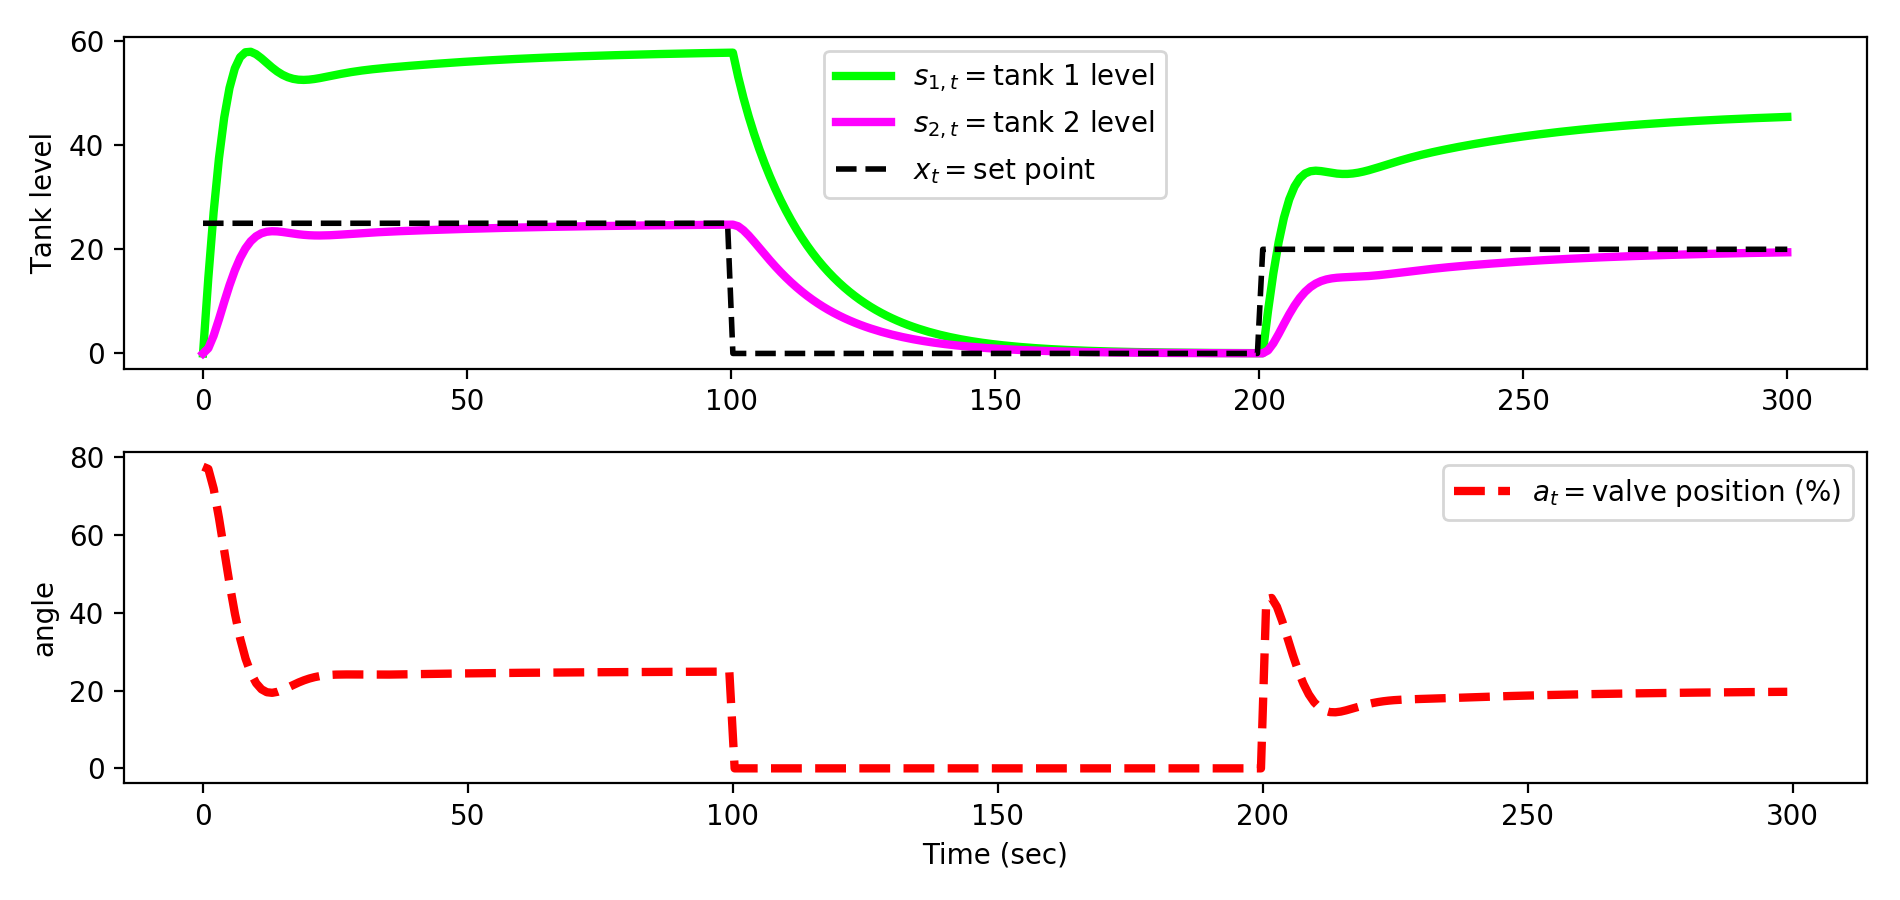

In [4]:
## This code cell will not be shown in the HTML version of this notebook
# create an instance of the car simulator
demo_3 = pidlib.two_tank_simulator.MyTanks()

# create a training sequence of *set points* for trying out the true simulator, and for learning a controller
x_tank2 = demo_3.create_set_points()

# feed in set point tests and test response of simulator (our 'true' model)
demo_3.test_response(set_points = x_tank2,w_1 = 3,w_2 = 0.1)

#### <span style="color:#a50e3e;">Example 4: </span> Cruise control in an automobile

<figure>
<p>
<img src= 'images/cruise_control_system.png' width="70%" height="70%" alt=""/>
</p>
</figure>

- $x_t$ the desired *set point* of the system at time step $t$ = desired speed of the vehicle

- $s_t$ the current setting or *state* of the system at time step $t$ = current speed of vehicle

- $a_t$ the action to take at time step $t$ =  *angle at which the gas pedal is depressed*

<IPython.core.display.Javascript object>


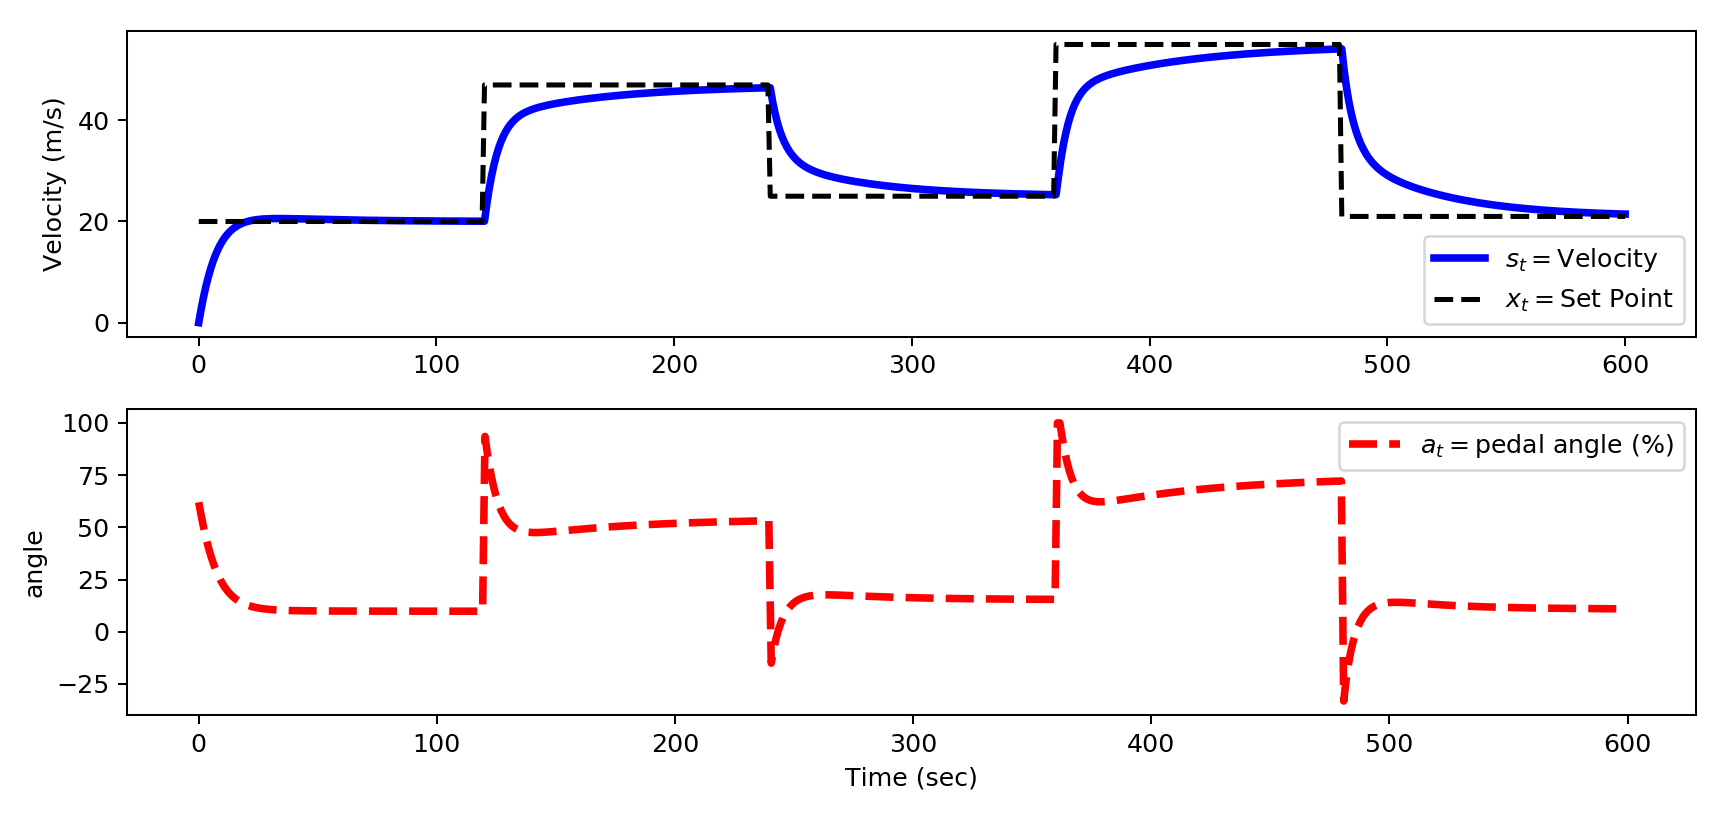

In [15]:
## This code cell will not be shown in the HTML version of this notebook
# create an instance of the car simulator
demo_1 = pidlib.car_simulator.MyCar()

# create a training sequence of *set points* for trying out the true simulator, and for learning a controller
# step_heights = [np.random.randint(10,75) for v in range(20)]
step_heights = np.array([20, 47, 25, 55, 21])
steps = [0,120,240,360,480]
num_pts = 600
x_car = demo_1.create_set_points(step_heights=step_heights,steps=steps,num_pts=num_pts)

# feed in set point tests and test response of simulator (our 'true' model)
demo_1.test_response(set_points = x_car,w_1 = 3,w_2 = 0.1)

- note here that a negative angle means "apply the brakes"

#### <span style="color:#a50e3e;">Example 5: </span> Self-driving vehicles

<figure>
<p>
<img src= 'images/self_driving_system.png' width="70%" height="70%" alt=""/>
</p>
</figure>

- $x_t$ the desired *set point* of the device at time step $t$ = desired location + velocity at time $t$ 

- $s_t$ the current setting or *state* of the system at time step $t$ = current location and velocity at time $t$

- $a_t$ the action to take at time step $t$ =  *angle at which the gas pedal is depressed* and *steering wheel orientation at time $t$

<figure>
<p>
<img src= 'images/mario_kart_imitation.gif' width="70%" height="70%" alt=""/>
</p>
</figure>


<div align="center">
[Image source](https://github.com/kevinhughes27/TensorKart)
</div>

---

# System Identification and Imitation Learning

- to construct an automatic controller we can first build a model of how a given device or agent (e.g., a heater, a car) behaves using (ideally) a representative sample of data from its environment


- this can be done with the device itself, or if this is too expensive a simulator of the device and system (e.g., a simulated car and test environments)


- we can use this *system model* or *imitation model* as a representative of the given device, and test various ways of automatically controlling it


- the process of building this model of the agent is called *system identification* or *imitation learning* (the former being more popular in the control community, the latter in the machine learning community)

- in some instances a model can be formed from *first principles* (e.g., physical or chemical fundamentals) as a *dscrete differential equation*, whose parameters are often tuned by assuming a simple structure for the system (e.g., that it is order one or two, and linear), and validated on a small dataset


- this necessitates a huge amount of expert knowledge about e.g., physical, chemical, etc., processes which is doable in a wide range of applications


- at the other end other of the spectrum is the machine learning approach: in place of expert knowledge we choose a flexible parameterized model and tune its parameters over a large dataset, cross-validating to ensure that the correct nonlinearity has been chosen (this is where we focus)


- there is plenty of space inbetween these two extremes - where expert knowledge crafts important aspects of design, and machine learning is applied to deal with the unknown / pieces where data can be generated cheaply

## Collecting data

- suppose we have the device / a simulator of the device (and environment) we wish to learn how to control


- to create training / validation data we run our device in the environment and collect state / action pairs


- that is we begin at some initial state $s_1$, take some action $a_1$ that leads to a second state $s_2$, take a second action $a_2$ that leads us to a third state $s_3$, and so on


- doing this we create two sequences (of states and actions)
$$
s_1,\,s_2,\,...,s_T \\
\,\,\,\,\,\, a_1,\,a_2,\,...,a_{T-1}
$$

- they are generated in pairs like this

<figure>
<p>
<img src= 'images/state_action_steps.png' width="70%" height="70%" alt=""/>
</p>
</figure>


- we can collectively refer to them as 'experience'


- these pairs can be created by 
    - choosing actions at random (e.g., thermostat or tank problems) - where random sample can represent the entire set of state/action pairs reasonably well
    - having an 'expert' navigate an environment in a way we want to directly imitate and generalize (e.g., self-driving vehicle) - where the entire set of state/action pairs is too large effectively sample at random
    - something inbetween (some expert and random experience)

<figure>
<p>
<img src= 'images/experiences_tank.png' width="70%" height="70%" alt=""/>
</p>
</figure>

<figure>
<p>
<img src= 'images/experiences_self_driving.png' width="70%" height="70%" alt=""/>
</p>
</figure>

## Imitator modeling

- with a set of experiences in hand, we can then train an imitator model (that we wish to faithfully imitate our agent's behavior) 


- this is a parameterized model $f_{\text{imitator}}$ whose parameters we tune to our collected experiences


- simplest form such a model can take: takes in a current state / action pair, and outputs the next state


\begin{equation}
s_{t+1} = f_{\text{imitator}}\left(s_t,a_t\right)
\end{equation}


- many devices can be faithfully modeled this way - e.g., thermometer, simple car

- sometimes we'll write out this model with its parameters explicitly

\begin{equation}
s_{t+1} = f_{\text{imitator}}\left(s_t,a_t; \Theta_{\text{imitator}}\right)
\end{equation}

where $\Theta_{\text{imitator}}$ is the set of internal parameters of the model that require tuning



- e.g., a model relating continuous $s_t$, $a_t$, and $s_{t+1}$ like e.g., the simplest --> linear

\begin{equation}
f_{\text{imitator}}\left(s_t,a_t; \Theta_{\text{imitator}}\right) = w_0 + w_1s_t + w_2a_t
\end{equation}

<figure>
<p>
<img src= 'images/imitator_model.png' width="70%" height="70%" alt=""/>
</p>
</figure>

- from a probabilistic perspective, this 'simplest' model is an order 1 Markov chain - a parameterized limited memory dynamic system

\begin{equation}
P\left(s_{t+1} \vert s_t,\,s_{t-1},...,s_1,\,a_t,a_{t-1},...,a_1\right) = P\left(s_{t+1} \vert s_t,a_t\right)
\end{equation}


- when a Markov chain includes an 'action' or 'decision' like this, it is called a Markov Decision Process (MDP)

## More complicated imitator modeling

- in general however our model could certainly be more complicated - depending on the device we are studying - precisely in the kind of terms we have discussed thus far: general limited or unlimited memory dynamic system


- e.g., making it limited memory with window length $D$ in both states and actions

\begin{equation}
s_{t+1} = f_{\text{system}}\left(s_t,s_{t-1},..,s_{t-D},a_t,a_{t-1},...,a_{t-D}\right)
\end{equation}

- we could also use an unlimited memory dynamic system model (these often arise from 'first principle' modeling, where a system is modeled via a differential equation)


- e.g., at each step we feed in summarizing (hidden state) variable for the history of *actions* $h^a_t$ as 

\begin{equation}
s_{t+1} = f_{\text{imitator}}\left(s_t,a_t,h^a_t\right)
\end{equation}


- at each step a summary / hidden state version of $s_t$ and $a_t$ are updated internally in the system, and used in defining system model


- of course we could also include a history variable on the state history as well


- however for the sake of simplicity as we move forward we will couch our discussion assuming the use of the simplest system model 


\begin{equation}
s_{t+1} = f_{\text{imitator}}\left(s_t,a_t\right)
\end{equation}

## Training the imitator model

- with experiences and a model in hand we can tune its parameters via the standard machine learning / cost function minimizing approach


- e.g., if states are continuous then we *regress*, and aim to tune $\Theta_{\text{imitator}}$ so that for 

\begin{equation}
f_{\text{imitator}}\left(s_t,a_t; \Theta_{\text{imitator}}\right) \approx s_{t+1}
\end{equation}


- to recover weights that force this to hold as well as possible, minimize e.g., a Least Squares cost

\begin{equation}
\frac{1}{T-1}\sum_{t=1}^{T-1}\left(f_{\text{imitator}}\left(s_t,a_t; \Theta_\text{imitator}\right) - s_{t+1}\right)^2
\end{equation}


- if states are finite and *discrete* use an appropriate classification cost

- Lets look at a simple `Python` implementation of this using a simple linear model

In [2]:
# A simple (order 1 MDP, linear) system model implementation
def system_model(s_t,a_t,w):
    return w[0] + w[1]*s_t + w[2]*a_t

In [3]:
# loop for evaluating system_model over all input/output action/state pairs
def system_loop(w,a,s):
    # compute least squares over all system model outputs at once
    s_predict = [s[:,0]]  # container for system_model state outputs
    for t in range(a.shape[1]):
        # get current action-state pair
        a_t = a[:,t]
        s_t = s[:,t]
        
        # feed into system_model to get predicted output
        s_hat = system_model(s_t,a_t,w)
        
        # store prediction
        s_predict.append(s_hat)
        
    # array-afy predictions and return
    return np.array(s_predict).T

In [4]:
# an implementation of the least squares cost for system identification
# note here: s is an (1 x T) array and a an (1 x T-1) array
def least_squares(w,a,s):
    # system_loop - runs over all action-state pairs and produces entire
    # state prediction set
    s_predict = system_loop(w,a,s)

    # compute least squares error between real and predicted states
    cost = np.sum((s_predict[:,1:] - s[:,1:])**2)
    return cost/float(s.shape[1]-1)

#### <span style="color:#a50e3e;">Example: </span> Learning cruise control 

<figure>
<p>
<img src= 'images/cruise_control_system.png' width="70%" height="70%" alt=""/>
</p>
</figure>

<IPython.core.display.Javascript object>


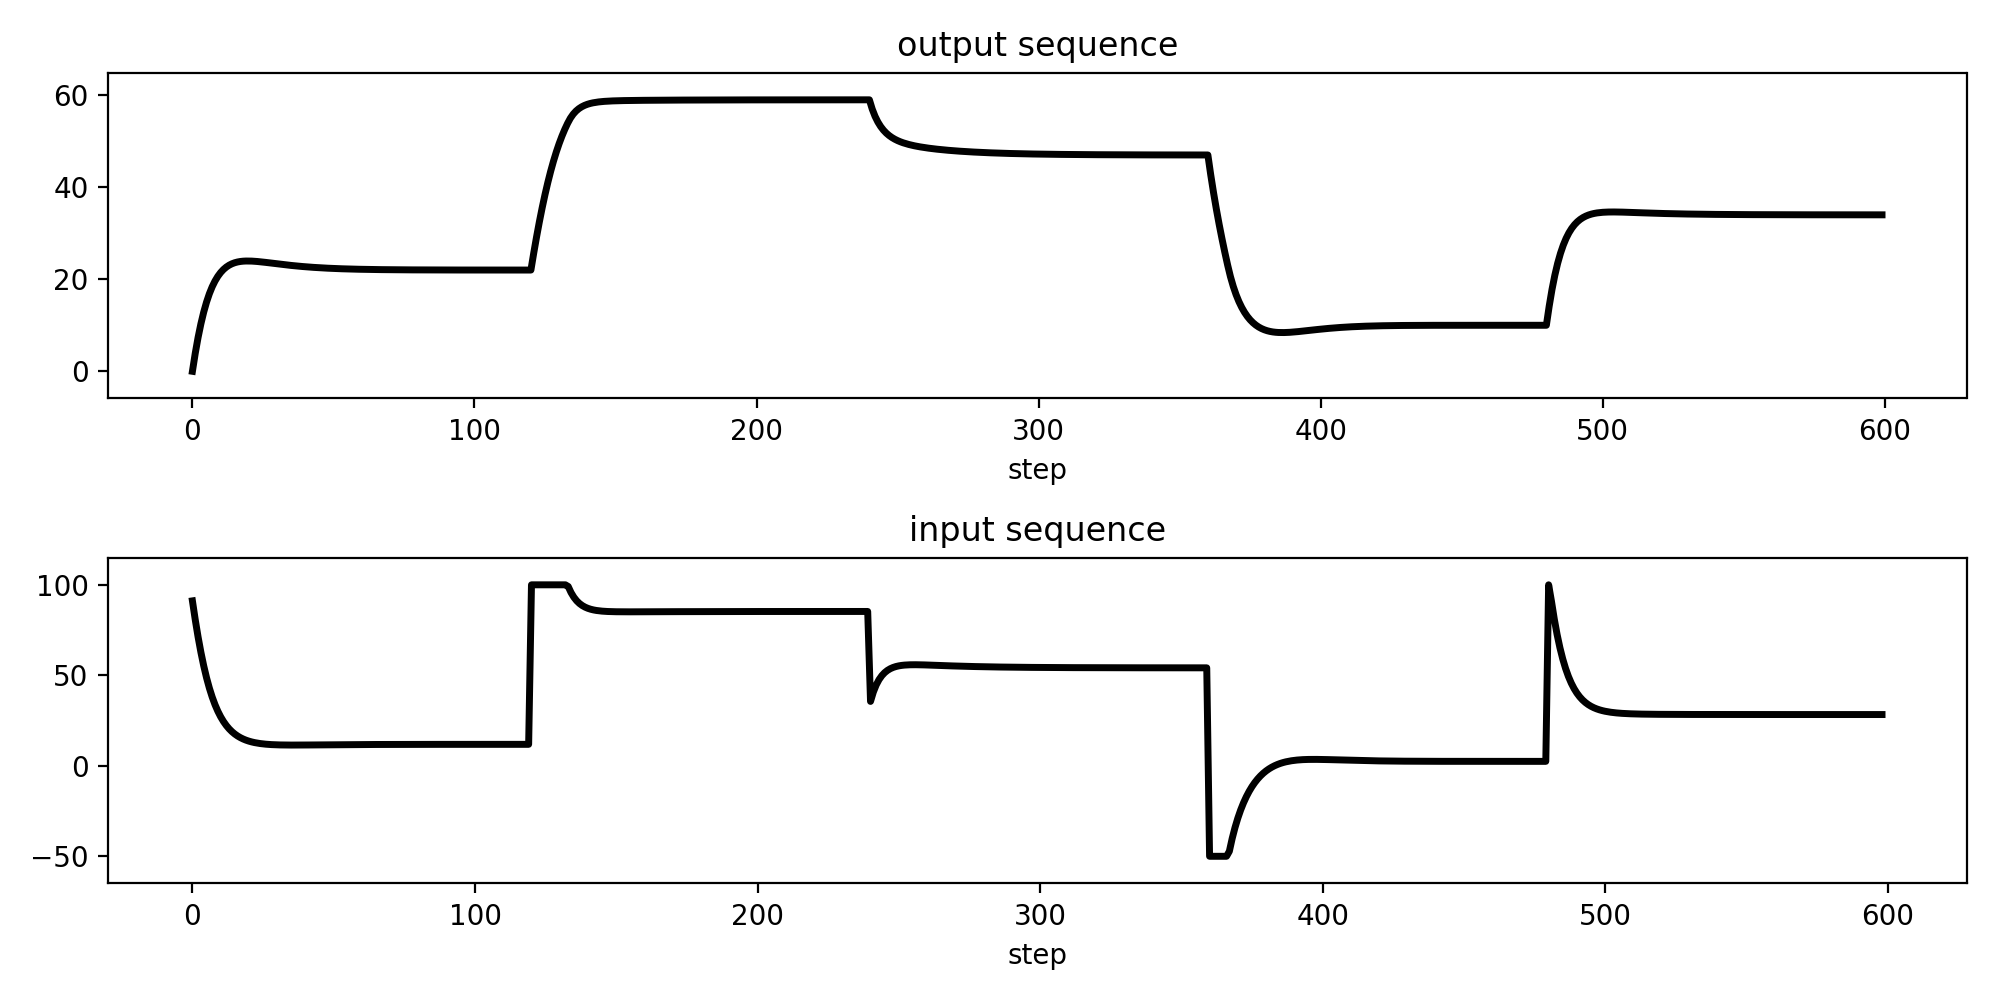

In [5]:
## This code cell will not be shown in the HTML version of this notebook
# load in simulated data
data = np.loadtxt(datapath + 'simulated_car_data.csv',delimiter = ',')

# extract actions and states 
actions = data[0,1:][np.newaxis,:]
states = data[1,:][np.newaxis,:]

# plot the test pair
pidlib.variable_order_plotters.plot_pair(actions,states,plot_type = 'continuous')

<IPython.core.display.Javascript object>


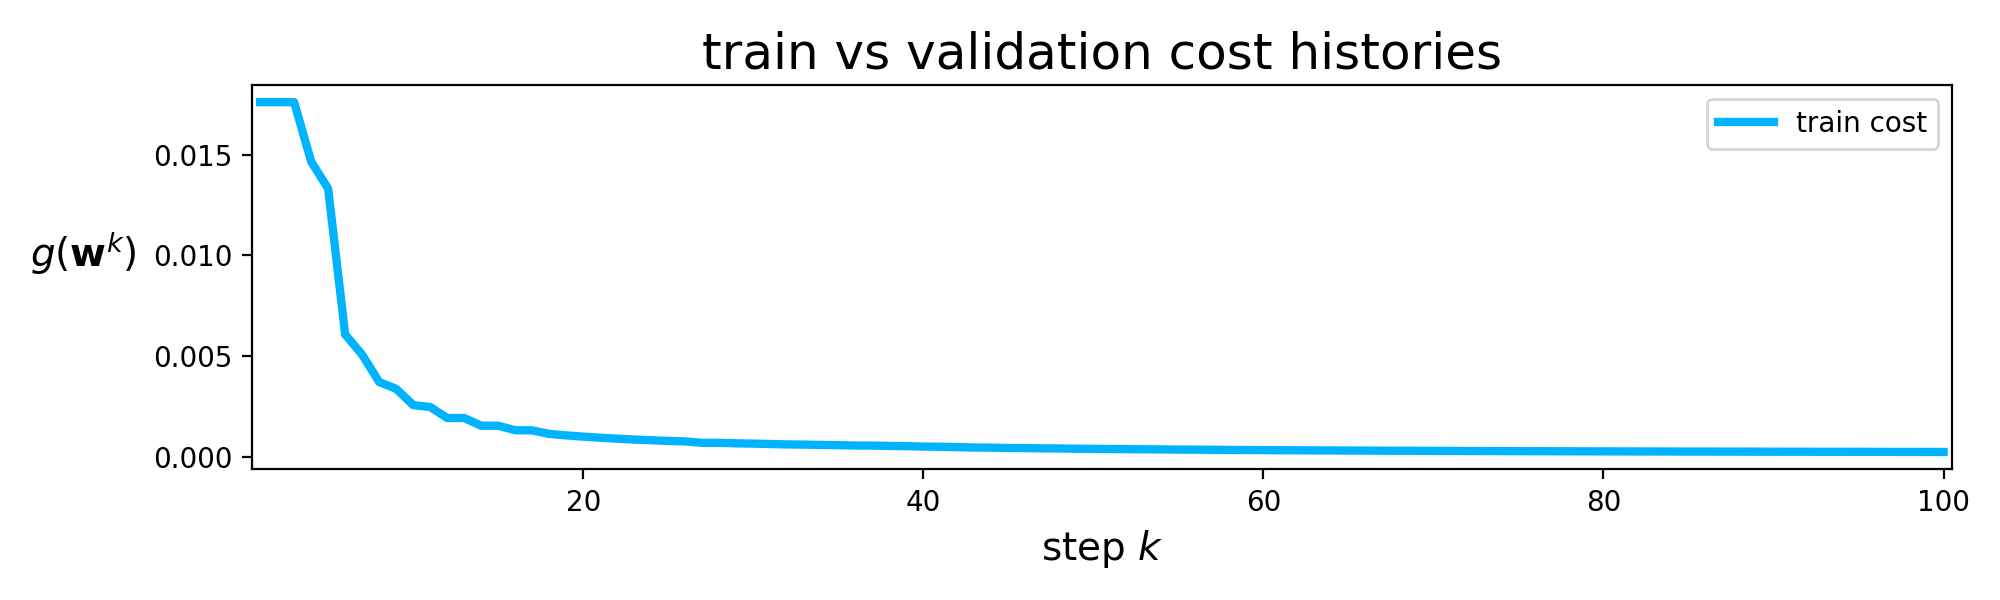

In [6]:
# This code cell will not be shown in the HTML version of this notebook
# initialize with input/output data
mylib1 = pidlib.rnn_sys_lib.super_setup.Setup(actions,states)

# normalize input
mylib1.preprocessing_steps(normalizer_name = 'standard')

# split into training and validation sets
mylib1.make_train_val_split(train_portion = 1)

# choose cost
mylib1.choose_cost(system_loop,cost = least_squares)

# fit an optimization
w = 0.1*np.random.randn(3,1)

mylib1.fit(max_its = 100,alpha_choice = 'diminishing',optimizer = 'zero_order',w_init = w,verbose = False)
# mylib1.fit(max_its = 30,alpha_choice = 10**(-2),optimizer = 'gradient_descent',w_init = w,verbose = False)

# show cost function history
mylib1.show_histories(start = 1)

- Below our system model fit in blue, the original output (state) in black

<IPython.core.display.Javascript object>


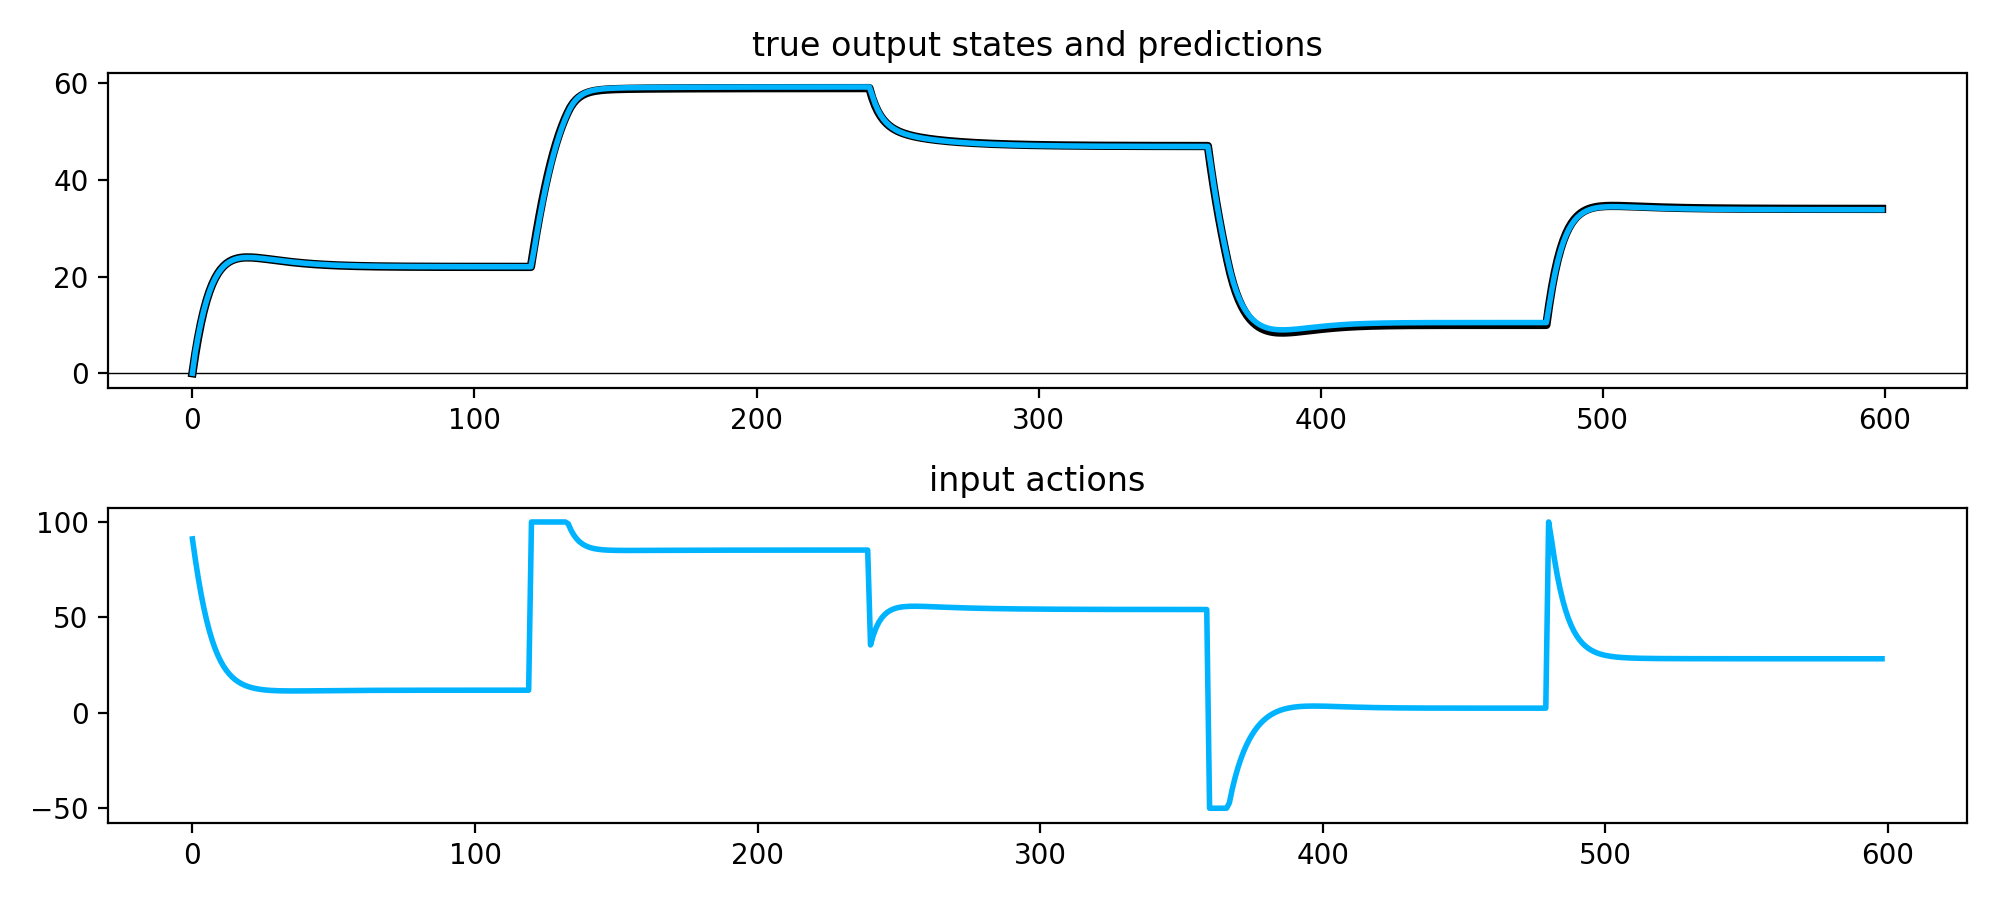

In [7]:
# This code cell will not be shown in the HTML version of this notebook
# Plot the standard normalized series and its training fit
pidlib.variable_order_plotters.plot_train_val_sequences(mylib1)

# Cross-validation

- we need to cross-validate to get the ideal parameters (so that our imitator model generalizes as well as possible on the experiences we have collected)


- below - the same system model tuned using $\frac{1}{3}$ of the time series as validation, with parameters tuned to minimize validation error


- blue fit is training, yellow is validation - model looks good

<IPython.core.display.Javascript object>


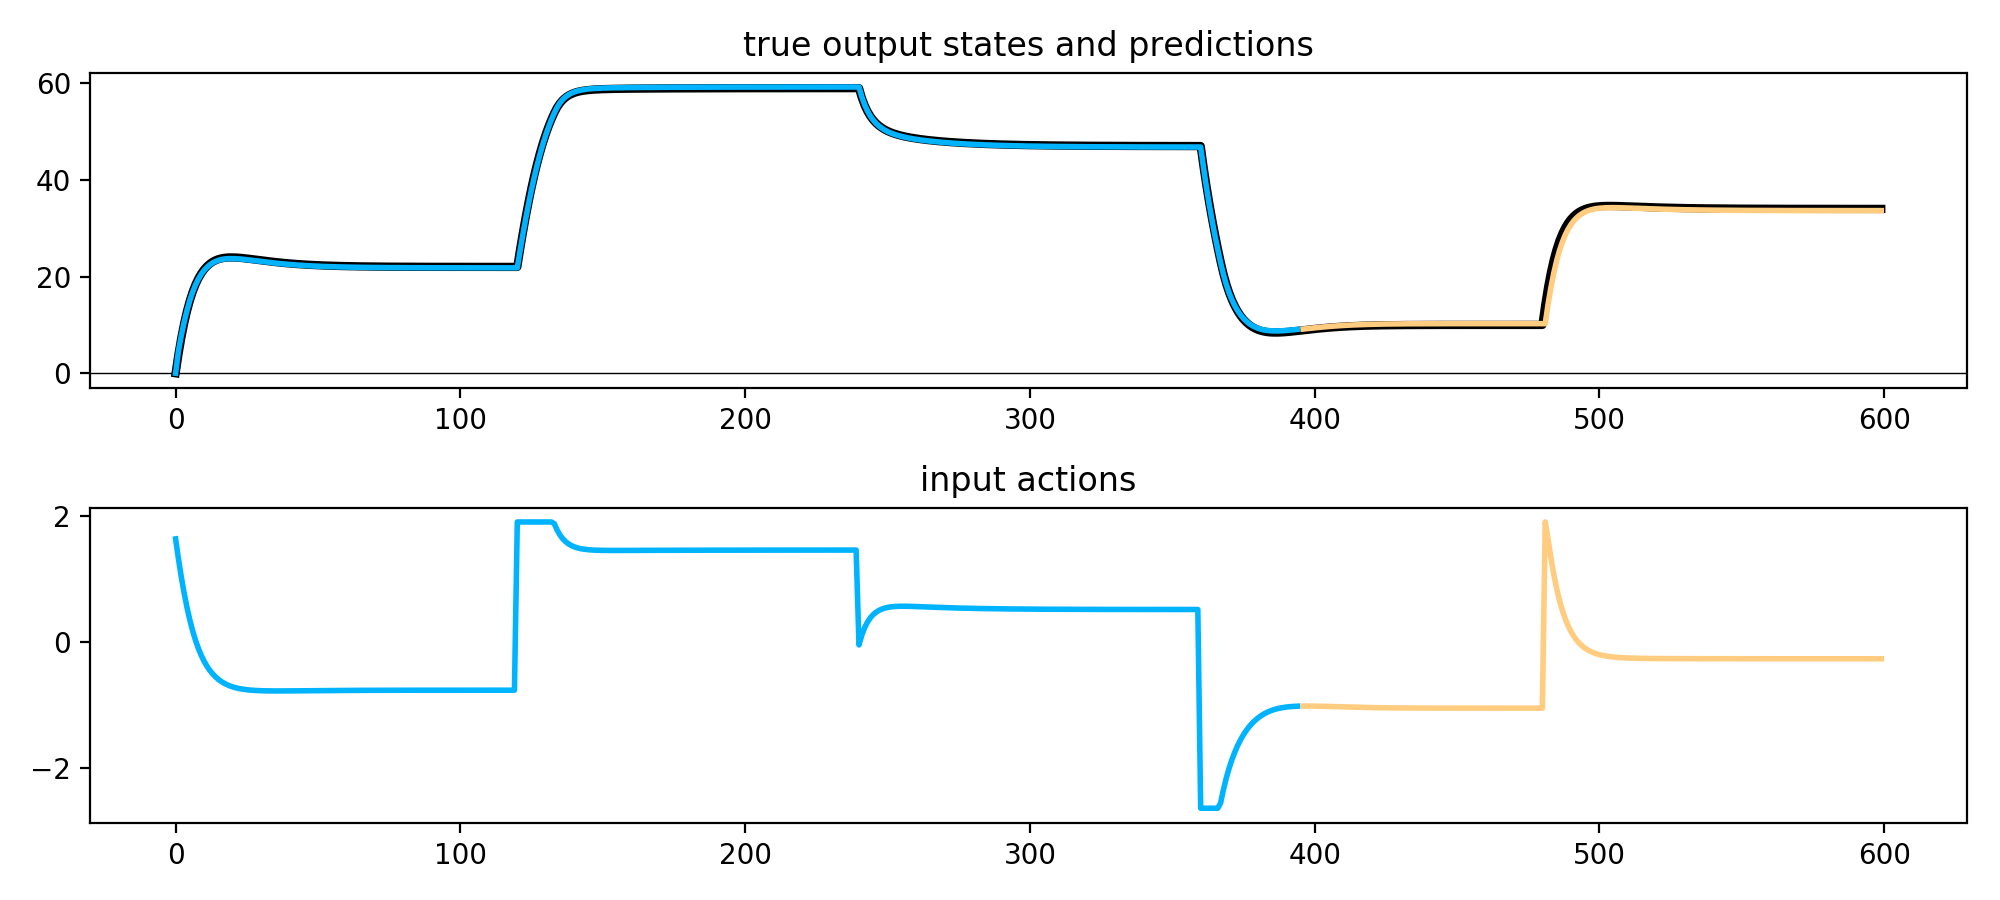

In [11]:
# This code cell will not be shown in the HTML version of this notebook
# initialize with input/output data
mylib2 = pidlib.rnn_sys_lib.super_setup.Setup(actions,states)

# normalize input
mylib2.preprocessing_steps(normalizer_name = 'standard')

# split into training and validation sets
mylib2.make_train_val_split(train_portion = 0.66)

# choose cost
mylib2.choose_cost(system_loop,cost = least_squares)

# fit an optimization
w = 0.1*np.random.randn(3,1)

mylib2.fit(max_its = 100,alpha_choice = 'diminishing',optimizer = 'zero_order',w_init = w,verbose = False)
# mylib1.fit(max_its = 30,alpha_choice = 10**(-2),optimizer = 'gradient_descent',w_init = w,verbose = False)

# Plot the standard normalized series and its training fit
pidlib.variable_order_plotters.plot_train_val_sequences(mylib2)

#### <span style="color:#a50e3e;">Example: </span> Real two-tank system identification

<figure>
<p>
<img src= 'images/two_tank_system.png' width="40%" height="40%" alt=""/>
</p>
</figure>

- here our action $a_t$ is the amount of liquid dumped into the first tank


- this systm has two (hidden) states have two states to keep track of, a top tank level $s_1$ that takes in and a bottom tank level $s_2$


- the level of the top tank / the first state we can intuitively model as a linear combination of its previous level and the current action

\begin{equation}
s_{1,t+1} = w_0 + w_1s_{1,t} + w_2a_2
\end{equation}


- the second tank we can then model as a linear combination of its previous level and that of the tank above it as

\begin{equation}
s_{2,t+1} = w_3 + w_4s_{2,t} + w_5s_{1,t}
\end{equation}

<IPython.core.display.Javascript object>


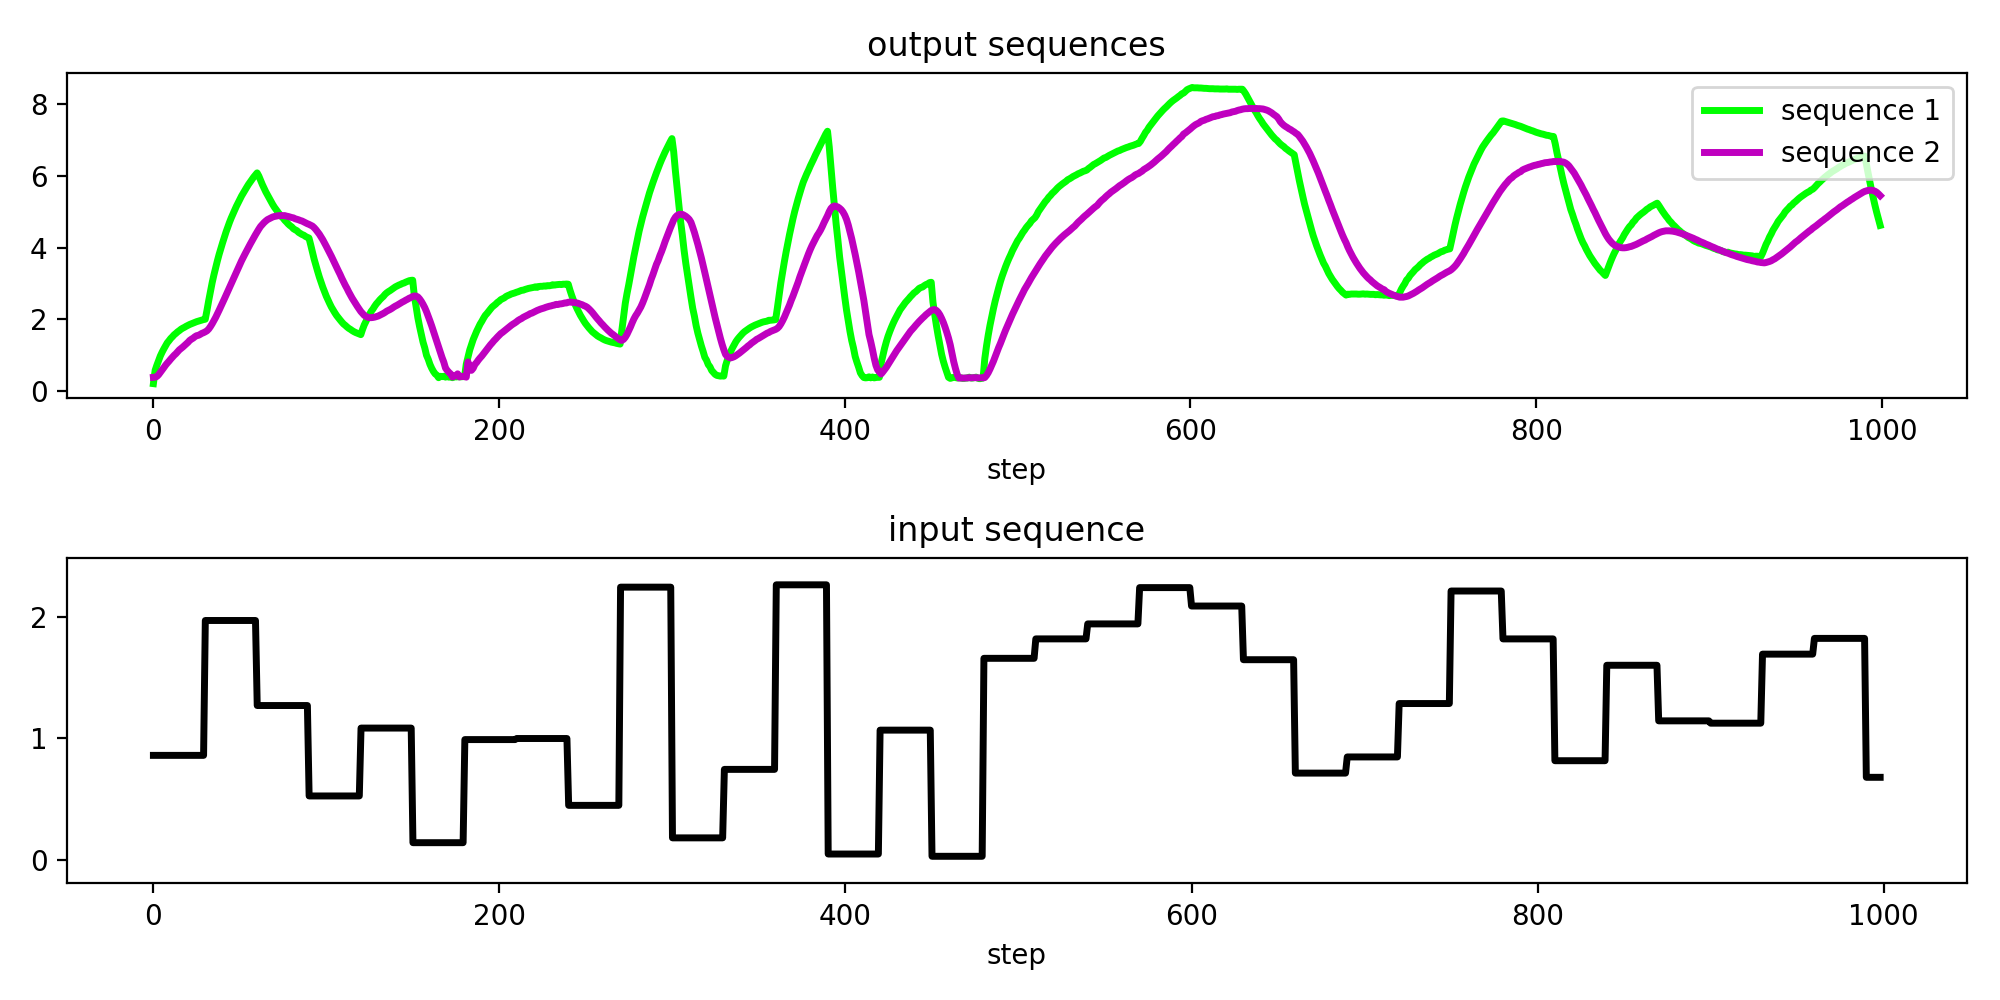

In [53]:
# This code cell will not be shown in the HTML version of this notebook
# load series
input_csv = datapath + 'cascaded_tanks_1.csv'
data = np.loadtxt(input_csv,delimiter = ',')
actions = data[0:1,:999]
states = data[1:,:1000]
states = np.flipud(states)

# plot the test pair
pidlib.variable_order_plotters.plot_3fer(actions,states[0],states[1],plot_type = 'continuous')

In [120]:
# A simple (order 1 MDP, linear) system model implementation
def system_model(s_t,a_t,w):
    # update equation for top tank
    s1_new = w[0] + w[1]*s_t[0] + w[2]*a_t
    s2_new = w[3] + w[4]*s_t[1] + w[5]*s_t[0]
    s_new = np.array([s1_new,s2_new])
    return s_new

# loop for evaluating system_model over all input/output action/state pairs
def system_loop(w,a,s):
    # compute least squares over all system model outputs at once
    s_predict = [s[1,0]]  # container for system_model state outputs
    for t in range(a.shape[1]):
        # get current action-state pair
        a_t = a[:,t]
        s_t = s[:,t]
        
        # feed into system_model to get predicted output
        s_hat = system_model(s_t,a_t,w)

        # store prediction
        s_predict.append(s_hat[1])
        
    # array-afy predictions and return
    s_predict = np.array(s_predict)
    return s_predict[np.newaxis,:]

# an implementation of the least squares cost for system identification
# note here: s is an (1 x T) array and a an (1 x T-1) array
def least_squares(w,a,s):
    # system_loop - runs over all action-state pairs and produces entire
    # state prediction set
    s_predict = system_loop(w,a,s)

    # compute least squares error between real and predicted states
    cost = np.sum((s_predict[:,1:] - s[1,1:])**2)
    return cost/float(s.shape[1]-1)

<IPython.core.display.Javascript object>


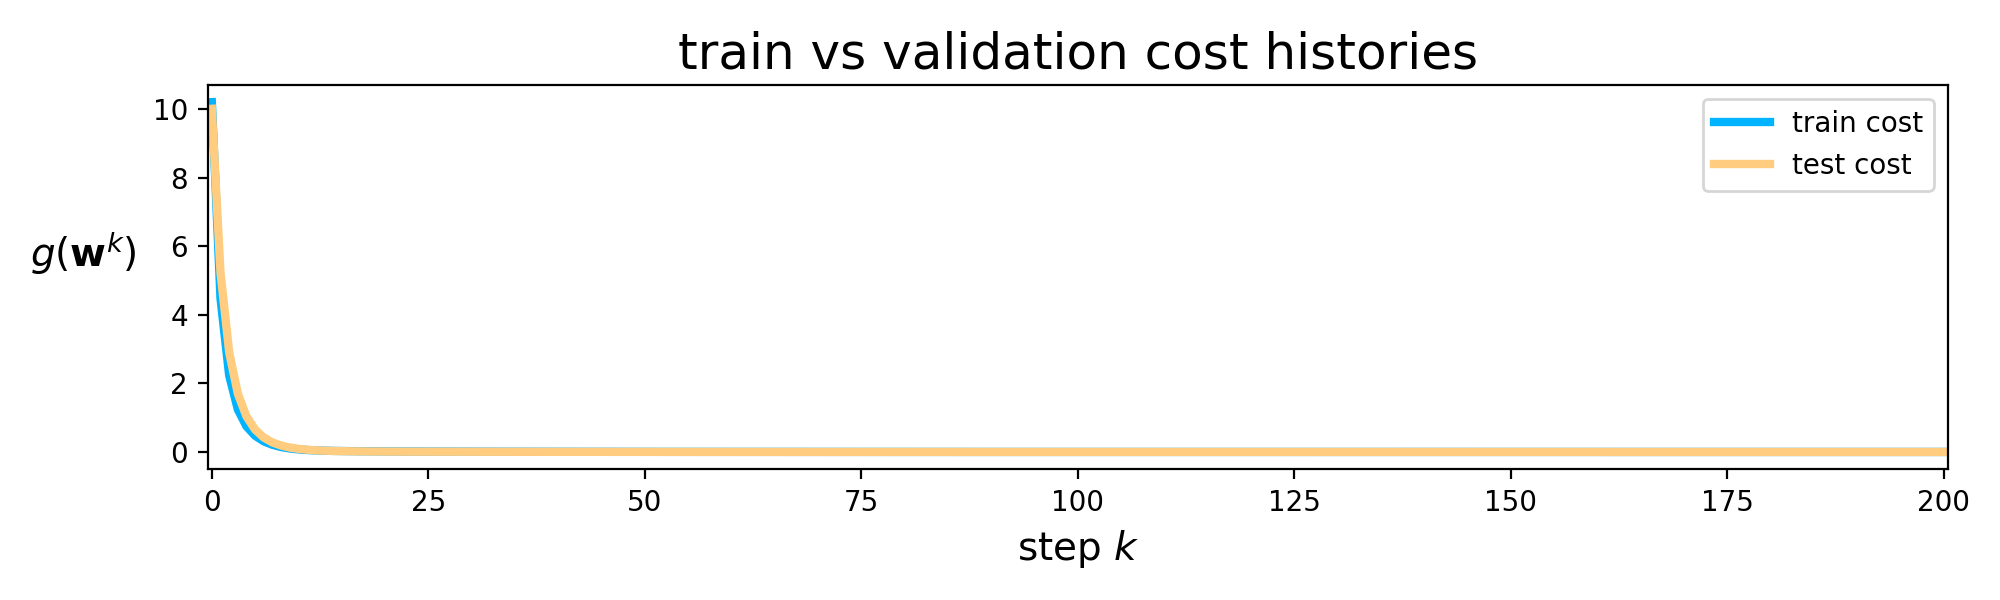

In [126]:
# This code cell will not be shown in the HTML version of this notebook
# initialize with input/output data
mylib4 = pidlib.rnn_sys_lib.super_setup.Setup(actions,states)

# normalize input
mylib4.preprocessing_steps(normalizer_name = 'standard')

# split into training and validation sets
mylib4.make_train_val_split(train_portion = 0.8)

# choose cost
mylib4.choose_cost(system_loop,cost = least_squares)

# fit an optimization
scale = 1
w = scale*np.random.randn(6,1)
# mylib1.fit(max_its = 25,alpha_choice = 'diminishing',optimizer = 'zero_order',w_init = w,verbose = False)
mylib4.fit(max_its = 200,alpha_choice = 10**(-1),optimizer = 'gradient_descent',w_init = w,verbose = False)

# show cost function history
mylib4.show_histories(start = 0)

<IPython.core.display.Javascript object>


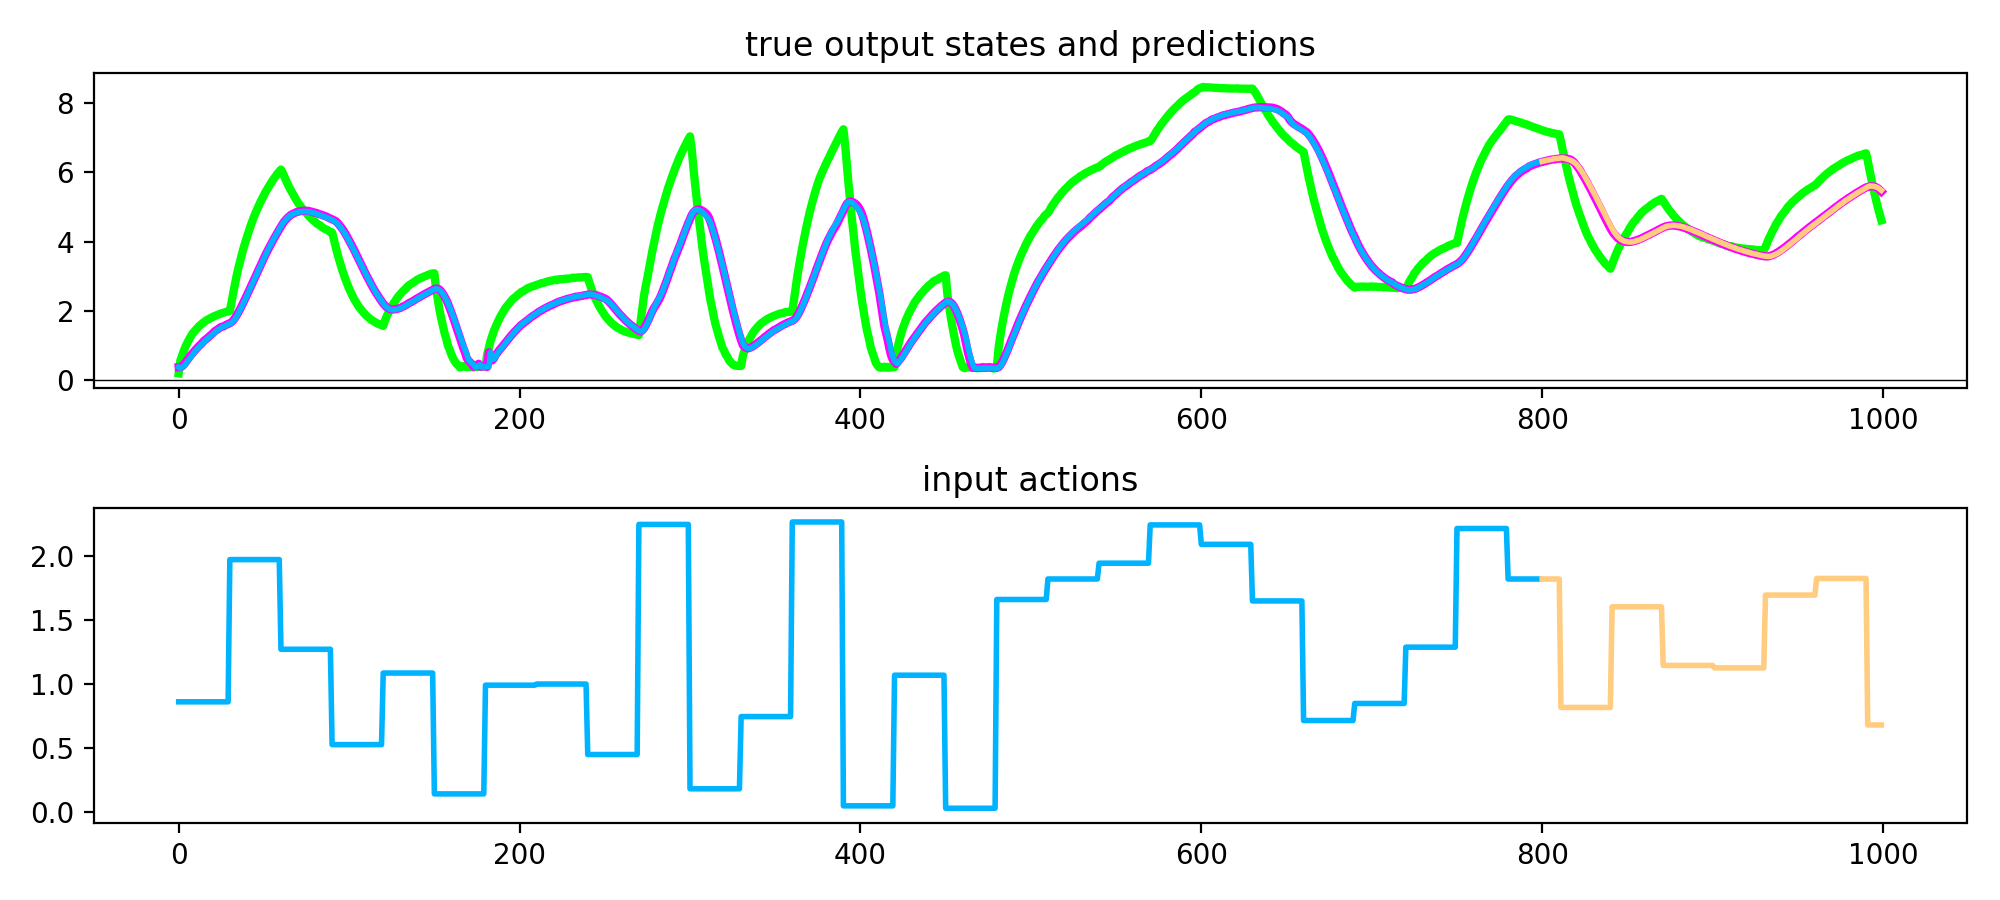

In [127]:
# This code cell will not be shown in the HTML version of this notebook
# Plot the standard normalized series and its training fit
pidlib.variable_order_plotters.plot_train_val_sequences_two(mylib4)

#### <span style="color:#a50e3e;">Example: </span> System identfication controller for Frequency Modulated (FM) radio

- say we wanted to undertand how FM radio works - and we had access to input/output data where


- $s_{t}$: modulated signal

- $a_t$: information to send over the airwaves


- we can use even the simple MDP order 1 system model to model this process fairly well

<IPython.core.display.Javascript object>


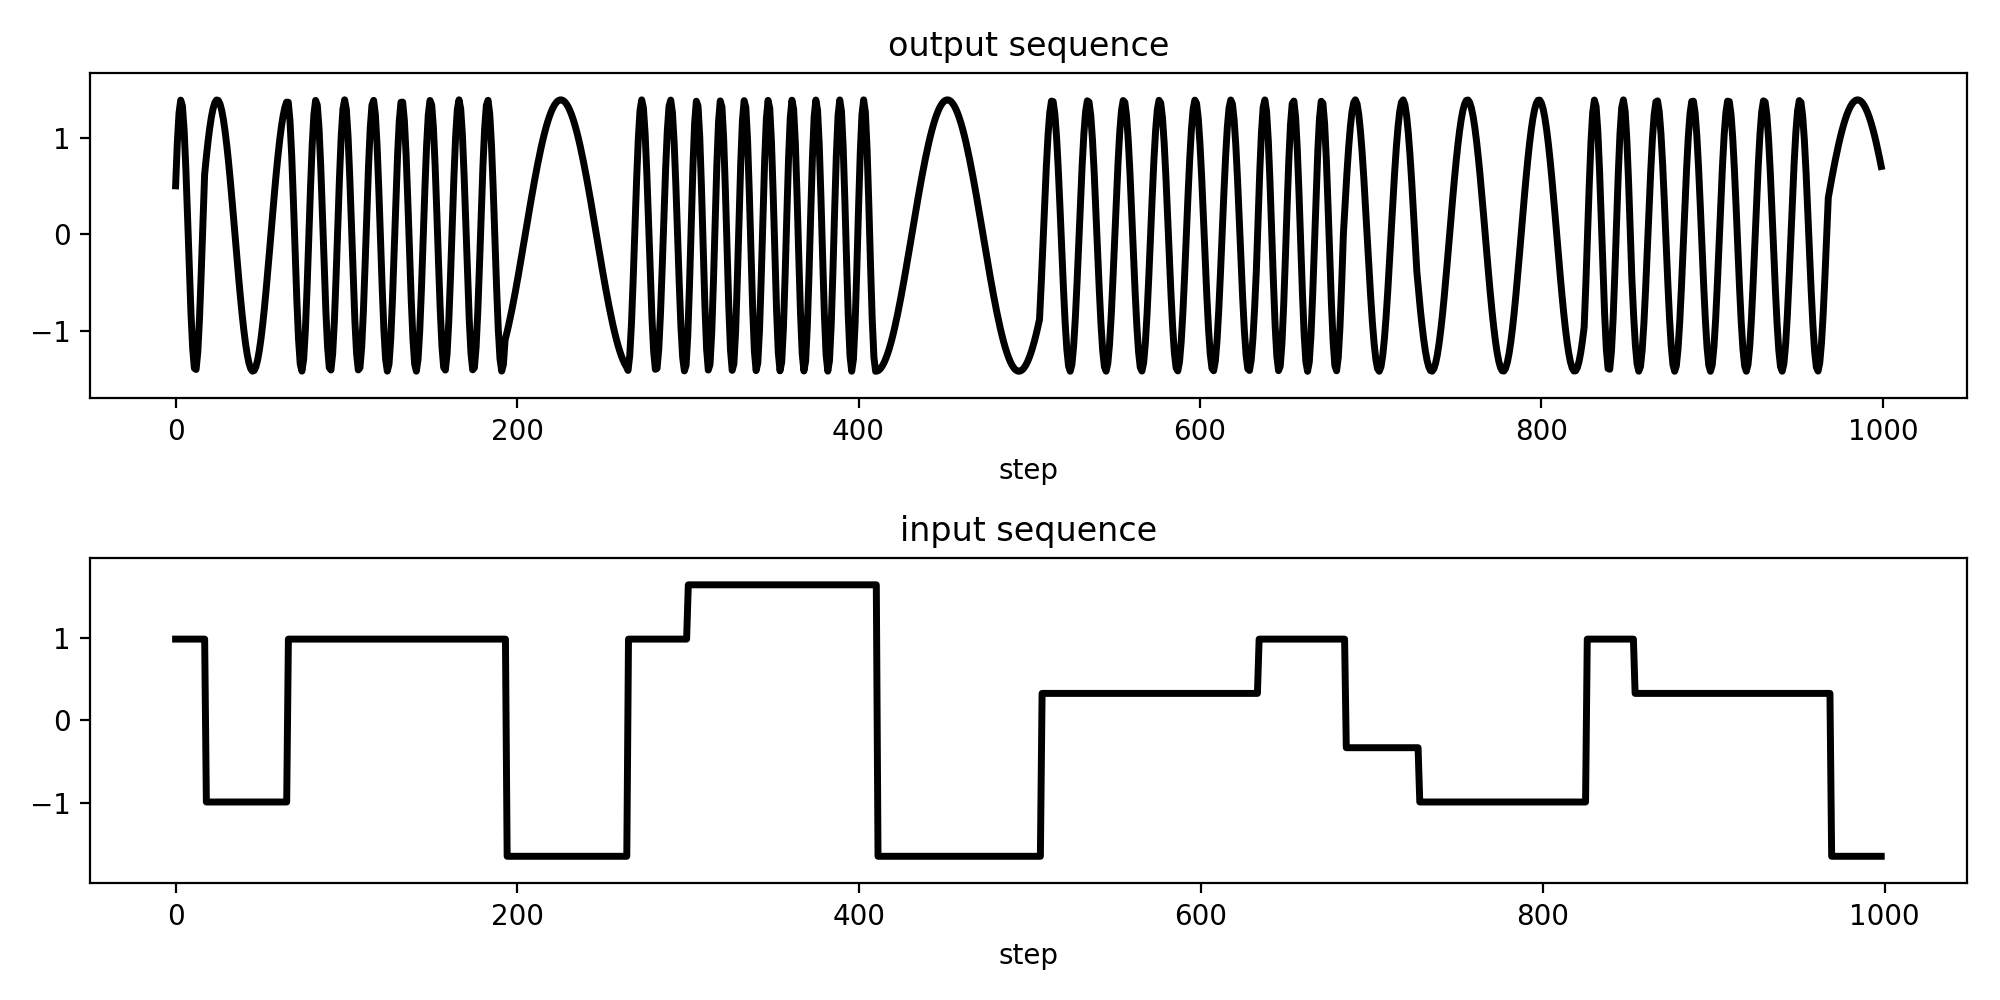

In [12]:
# This code cell will not be shown in the HTML version of this notebook
# load series
input_csv = datapath + 'input_freq.csv'
output_csv = datapath + 'output_signal.csv'
actions = np.loadtxt(input_csv,delimiter = ',')[np.newaxis,:999]
states = np.loadtxt(output_csv,delimiter = ',')[np.newaxis,:1000]

# plot the test pair
pidlib.variable_order_plotters.plot_pair(actions,states,plot_type = 'continuous')

<IPython.core.display.Javascript object>


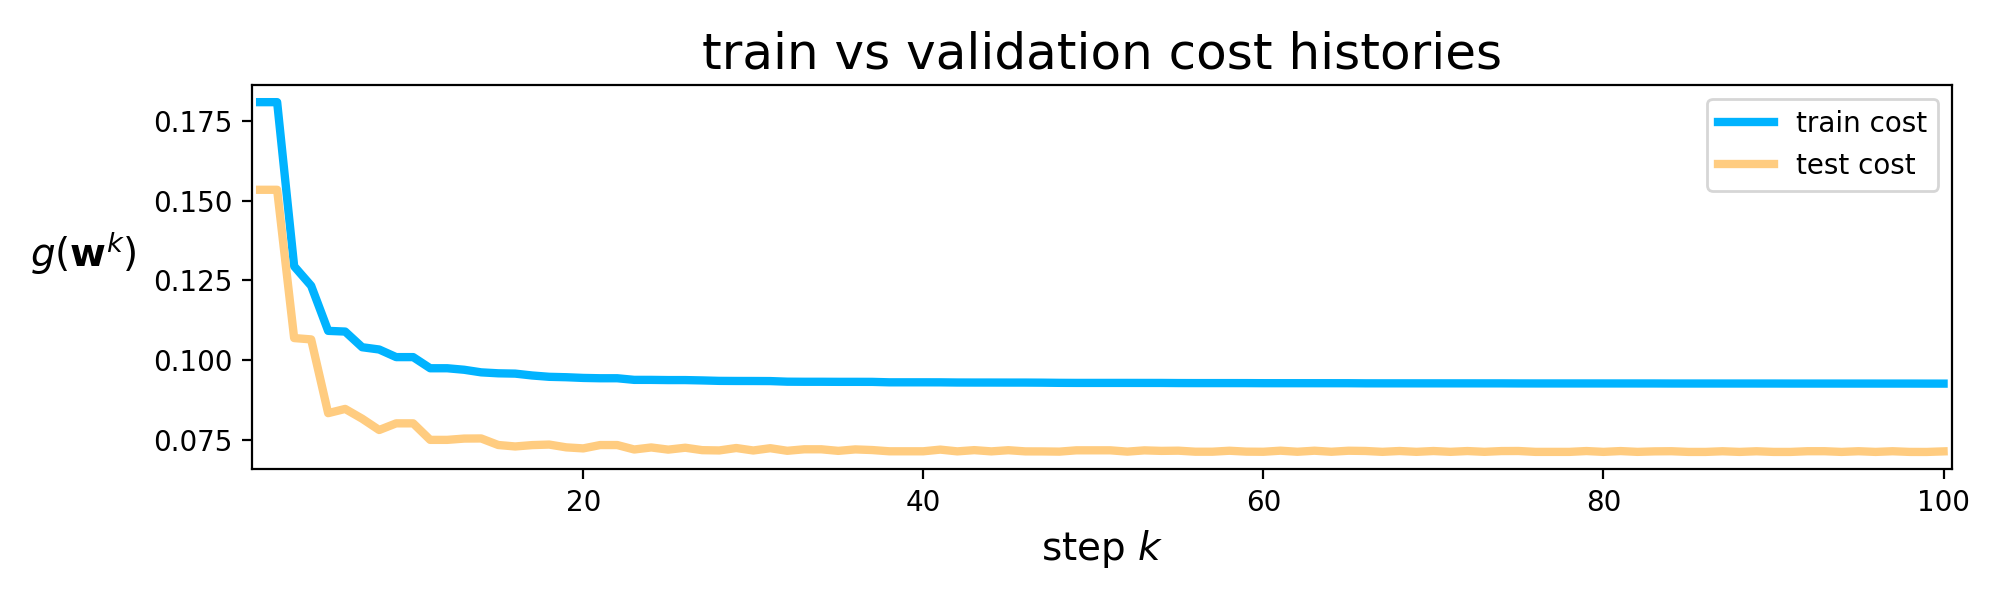

In [13]:
# This code cell will not be shown in the HTML version of this notebook
# initialize with input/output data
mylib3 = pidlib.rnn_sys_lib.super_setup.Setup(actions,states)

# normalize input
mylib3.preprocessing_steps(normalizer_name = 'standard')

# split into training and validation sets
mylib3.make_train_val_split(train_portion = 0.6)

# choose cost
mylib3.choose_cost(system_loop,cost = least_squares)

# fit an optimization
w = 0.1*np.random.randn(3,1)

mylib3.fit(max_its = 100,alpha_choice = 'diminishing',optimizer = 'zero_order',w_init = w,verbose = False)
# mylib1.fit(max_its = 30,alpha_choice = 10**(-2),optimizer = 'gradient_descent',w_init = w,verbose = False)

# show cost function history
mylib3.show_histories(start = 1)

- using $\frac{1}{3}$ of the data as validation we can tune the parameters of our system model


- below blue denotes training fit (in the case of state predictions) and input (in the case of actions), likewise yellow denotes validation data


- with such a model we could then start sending information with our FM-modeling system model

<IPython.core.display.Javascript object>


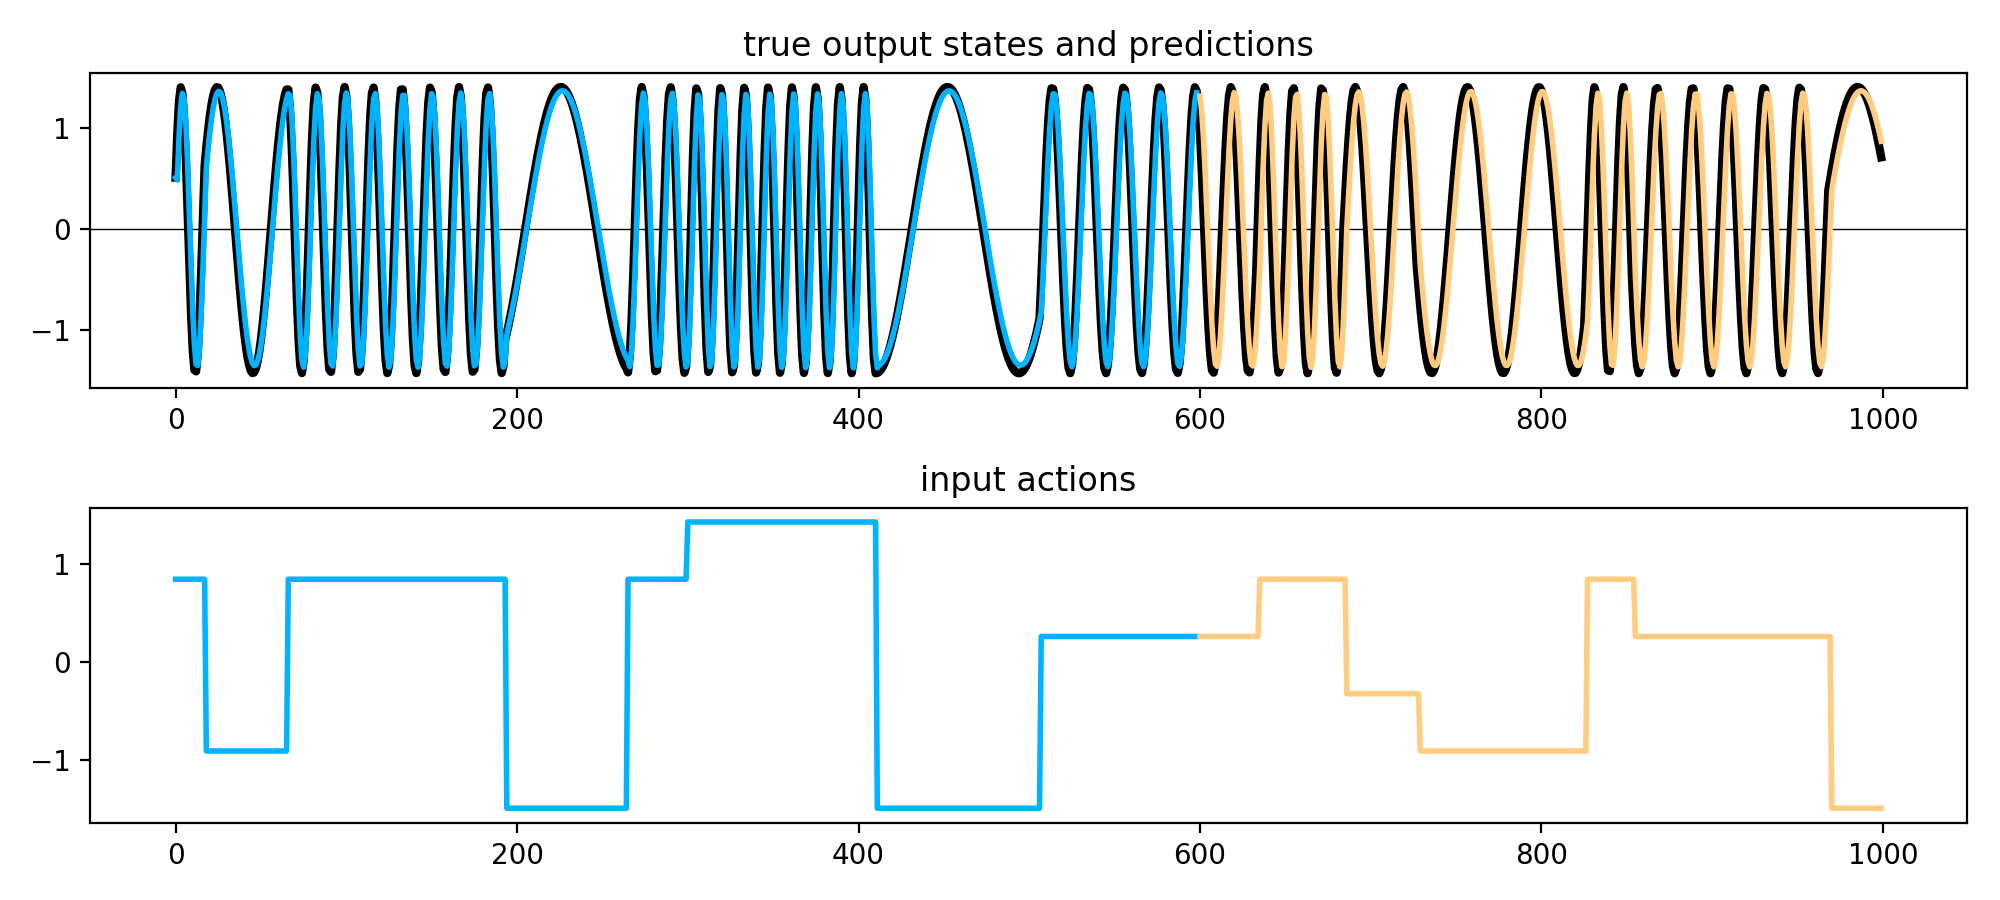

In [19]:
# This code cell will not be shown in the HTML version of this notebook
# Plot the standard normalized series and its training fit
pidlib.variable_order_plotters.plot_train_val_sequences(mylib3)

# The double edged sword of data-driven imitation

- data-driven Imitation Learning / System Identification is a double edged sword


- that is, its fundamental strength is also its fundamental weakness (like all supervised learning schemes) - real experience (data) baked into the parameters of a trained imitator
     
     
- **strength:** allows it to behave as desired on the data it was trained on, and generalize this behavior on similar data (via the use of appropriate modeling and cross-validation)


- **weakness:** prevent it from generalizing well to data it views as disimilar to training data, even if smarty-pants humans would not view such data as too disimilar from training

- this data-based weakness can be due to too few samples (with respect to the size of the input space / complexity of the underyling phenomenon) and / or due to poor distribution sampling


<figure>
<p>
<img src= 'images/limits.png' width="75%" height="75%" alt=""/>
</p>
<center>
<a href="https://github.com/jermwatt/machine_learning_refined">image source</a>
</center>
</figure>



- (left panel) An example of toy two-class dataset that is too small to adequately represent the underlying phenomenon that generates it.  Cross-validation leads to the learning of a linear boundary (solid black line) when the nonlinear dashed-black line represents the true boundary.


- (right panel) An example of a toy two-class dataset that is large but poorly distributed, with only samples in the top hemisphere having been sampled.  Cross-validation leads to the decision boundary in solid black, when the true boundary is a perfect circle.

- think by analogy to a supervised learning problem - face detection


- say you train a supervised learner on faces looking more or less straight at the camera with more or less horizontal orientation

<figure>
<p>
<img src= 'images/face_detections.jpg' width="40%" height="40%" alt=""/>
</p>
<center>
<a href="http://blog.dlib.net/2014/02/dlib-186-released-make-your-own-object.html">image source</a>
</center>
</figure>

- then - if you train well - your learner can generalize to detect *different people's faces* in new images


    
    
<figure>
<p>
<img src= 'images/face_detection_output.jpg' width="40%" height="40%" alt=""/>
</p>
<center>
<a href="https://github.com/arunponnusamy/cvlib">image source</a>
</center>
</figure>

- however your learner will NOT generalize too scenarios that are too far away from your limited training set, like

    - scales (small and large faces) it hasn't seen before
    - orientations (faces not more or less horizontally oriented)
    - directions (faces looking not directly at camera)
    - occlusions (e.g., sunglasses, beards, etc.,)

- the bottom two examples were not trained on smaller facial images, so they miss them


<figure>
<p>
<img src= 'images/face-detection-scale-comparison.gif' width="40%" height="40%" alt=""/>
</p>
<center>
<a href="https://www.learnopencv.com/face-detection-opencv-dlib-and-deep-learning-c-python/">image source</a>
</center>
</figure>

- dealing with occlusions is tough!


<figure>
<p>
<img src= 'images/fd-occlusion-result1.jpg' width="40%" height="40%" alt=""/>
</p>
<center>
<a href="https://www.learnopencv.com/face-detection-opencv-dlib-and-deep-learning-c-python/">image source</a>
</center>
</figure>

- to make a great face detector you need a good set of facial images, but you also want to *bootstrap* the hell out of them to try to better capture the true distribution of human faces


- that is, you take your faces and
    - scale them (make copies that are bigger and smaller than the original)
    - rotate them (make copies that are rotated) 
    - ...
    

- all so that - once trained - your detector can better find a wide class of faces, and you can detect a wider variety of faces 'in the wild'

- so what does this mean for Imitation Learning / System Identification?


- if you control or can scope the environment your agent lives in and you can generate data cheaply == you're in very good shape


- you can sample enough to approximate the true distribution of state / action pairs, in other words you can generate very rich training sets that reflect the complete reality your agent will experience in the future


- happens with control problems in fixed environments like factories, constrained chemical / physical processes, robotics in limited environments

- what if you can't control or can scope the environment your agent lives in, like e.g., a self-driving car?

- for example, say you recorded an 'expert' driver on a sunny day driving in a circuit


- you then properly train your imitator on these experiences alone 



<figure>
<p>
<img src= 'images/self_driving_sunny.png' width="70%" height="70%" alt=""/>
</p>
</figure>

- if you run your imitator on the same circuit on a sunny day you might imitate your expert's behavior well


- but what if its storming that day?  


<figure>
<p>
<img src= 'images/self_driving_storm.png' width="70%" height="70%" alt=""/>
</p>
</figure>

- you could be get into big trouble, because your imitator doesn't have the experience of a stormy drive e.g., wet pavement, it won't know how to respond


<figure>
<p>
<img src= 'images/self_driving_crash.png' width="70%" height="70%" alt=""/>
</p>
</figure>

- to deal with this kind of natural problem you'll need to 


- construct massive datasets - entire industries are being built to do this


- bootstrap your data like a champ - in completely analogous ways to the face detection example described above 


- recognize the natural limitation of what we now call 'machine learning', and engineer your self-driving solution accordingly